In [17]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from scipy.signal import find_peaks

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

import qiskit.pulse as pulse
import qiskit.pulse.library as pulse_lib
from qiskit.pulse.library import Waveform

from qiskit.tools.monitor import job_monitor
from qiskit.compiler import assemble


In [18]:
import warnings
warnings.filterwarnings('ignore')
from qiskit.tools.jupyter import *

In [19]:
backend = armonk_backend
backend.configuration().open_pulse

True

In [20]:
dt = backend.configuration().dt
backend_defaults = backend.defaults()

In [21]:
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds
qubit = 0 # qubit we will analyze
default_qubit_freq = backend_defaults.qubit_freq_est[qubit] # Default qubit frequency in Hz. 
print(f"Qubit {qubit} has an estimated frequency of {default_qubit_freq/ GHz} GHz.")
# scale data (specific to each device)
scale_factor = 1.
# number of shots for our experiments
NUM_SHOTS = 1024
### Collect the necessary channels
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)

Qubit 0 has an estimated frequency of 4.971852852405576 GHz.


In [22]:
def get_closest_multiple_of_16(num):
    """Compute the nearest multiple of 16. Needed because pulse enabled devices require 
    durations which are multiples of 16 samples.
    """
    return int(num)-(int(num)%16)


In [23]:
def get_job_data(job, average):
    """Retrieve data from a job that has already run.
    Args:
        job (Job): The job whose data you want.
        average (bool): If True, gets the data assuming data is an average.
                        If False, gets the data assuming it is for single shots.
    Return:
        list: List containing job result data. 
    """
    job_results = job.result(timeout=120) # timeout parameter set to 120 s
    result_data = []
    for i in range(len(job_results.results)):
        if average: # get avg data
            result_data.append(job_results.get_memory(i)[qubit]*scale_factor) 
        else: # get single data
            result_data.append(job_results.get_memory(i)[:, qubit]*scale_factor)  
    return result_data

In [24]:
# Drive pulse parameters (us = microseconds)
drive_sigma_us = 0.075                     # This determines the actual width of the gaussian
drive_samples_us = drive_sigma_us*8        # This is a truncating parameter, because gaussians don't have 
                                           # a natural finite length

drive_sigma = get_closest_multiple_of_16(drive_sigma_us * us /dt)       # The width of the gaussian in units of dt
drive_samples = get_closest_multiple_of_16(drive_samples_us * us /dt)   # The truncating parameter in units of dt

In [25]:
# Find out which measurement map index is needed for this qubit
meas_map_idx = None
for i, measure_group in enumerate(backend.configuration().meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"

In [26]:
# Get default measurement pulse from instruction schedule map
inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=backend.configuration().meas_map[meas_map_idx])

In [27]:
lorentzian = lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C
rabi_fun = lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B)


In [28]:
def get_schedule(_pulse, drive_channel, preprogram=None):
    if preprogram is None:
        preprogram = []
        
    schedule = pulse.Schedule(name='Drive ground state.')
    for _pulse, channel, _ in preprogram:
        if channel is None:
            channel = drive_channel
        schedule |= pulse.Play(_pulse, channel) << schedule.duration
    schedule |= pulse.Play(_pulse, drive_channel) << schedule.duration
    schedule |= measure << schedule.duration
    
    return schedule

In [29]:
def find_frequency(
    initial_guess,
    preprogram=None,
    width=40*MHz,
    num_freqs=75,
    drive_power=0.3,
    drive_sigma=drive_sigma,
    initial_fit_params=[7, 4.975*GHz, 1*GHz, 3*GHz],
):
    
    if num_freqs > 75:
        raise ValueError("You can only run 75 schedules at a time.")
    
    freqs = initial_guess + np.linspace(-width/2, width/2, num_freqs)
    
    # print information on the sweep
    print(f"The frequency sweep will go from {freqs[0] / GHz} GHz to {freqs[-1]/ GHz} GHz \
using {len(freqs)} frequencies. The drive power is {drive_power}.")
    
    # Define the drive pulse
    drive_ground_state = pulse_lib.gaussian(
        duration=drive_samples,
        sigma=drive_sigma,
        amp=drive_power,
        name='drive_ground_state_pulse'
    )
    drive_channel = pulse.DriveChannel(0)
    schedule = get_schedule(drive_ground_state, drive_channel, preprogram)
    
    # define frequencies for the sweep
    schedule_freqs = [
        {drive_channel: freq, **{channel: f for _, channel, f in preprogram if channel is not None}} 
        for freq in freqs
    ]

    # assemble the program
    drive_ground_state_program = assemble(
        schedule,
        backend=backend, 
        meas_level=1,
        meas_return='avg',
        shots=NUM_SHOTS,
        schedule_los=schedule_freqs,
    )
    drive_ground_state_job = backend.run(drive_ground_state_program)
    print(drive_ground_state_job.job_id())
    job_monitor(drive_ground_state_job)
    drive_ground_state_data = get_job_data(drive_ground_state_job, average=True)
    
    fitparams, conv = curve_fit(lorentzian, freqs, drive_ground_state_data, initial_fit_params)
    y_fit = lorentzian(freqs, *fitparams)
    
    plt.scatter(freqs/GHz, drive_ground_state_data, color='black')
    plt.plot(freqs/GHz, y_fit, color='red')
    plt.xlim([min(freqs/GHz), max(freqs/GHz)])
    plt.xlabel("Frequency [GHz]", fontsize=15)
    plt.ylabel("Measured Signal [a.u.]", fontsize=15)
    plt.title("0->1 Frequency Sweep", fontsize=15)
    plt.show()
    fitted_frequency = fitparams[1]
    
    return fitted_frequency

In [30]:
def find_amplitude(freq, num_amp=50, amp_min=0., amp_max=0.75, preprogram=None, 
                   initial_fit_params=[4, -4, 0.4, 0]):
    
    drive_amps = np.linspace(amp_min, amp_max, num_amp)
    
    drive_channel = pulse.DriveChannel(0)
    # Create schedule
    rabi_schedules = []
    # loop over all drive amplitudes
    for drive_amp in drive_amps:
        # drive pulse
        drive_ground_state = pulse_lib.gaussian(
            duration=drive_samples,
            sigma=drive_sigma,
            amp=drive_amp,
            name='drive_ground_state_pulse'
        )
        schedule = get_schedule(drive_ground_state, drive_channel, preprogram)

        rabi_schedules.append(schedule)
        
    rabi_program = assemble(
        rabi_schedules,
        backend=backend,
        meas_level=1,
        meas_return='avg',
        shots=NUM_SHOTS,
        schedule_los=[{drive_channel: freq}] * num_amp
    )
    
    rabi_job = backend.run(rabi_program)
    
    print(rabi_job.job_id())
    job_monitor(rabi_job)
    rabi_data = get_job_data(rabi_job, average=True)

    # Note: Only real part of data is plotted
    rabi_data = np.real(np.array(rabi_data)-np.mean(rabi_data))
    fitparams, conv = curve_fit(rabi_fun, drive_amps, rabi_data, initial_fit_params)
    y_fit = rabi_fun(drive_amps, *fitparams)
    
    plt.scatter(drive_amps, rabi_data, color='black')
    plt.plot(drive_amps, rabi_y_fit, color='red')

    drive_period = fitparams[2] 
    # account for phi in computing pi amp
    amp_01 = (drive_period/2/np.pi) *(np.pi+fitparams[3])

    plt.axvline(amp_01, color='red', linestyle='--')
    plt.axvline(amp_01+drive_period/2, color='red', linestyle='--')
    plt.annotate("", xy=(amp_01+drive_period/2, 0), xytext=(amp_01,0), arrowprops=dict(arrowstyle="<->", color='red'))
    plt.annotate("$\pi$", xy=(amp_01-0.03, 0.1), color='red')

    plt.xlabel("Drive amp [a.u.]", fontsize=15)
    plt.ylabel("Measured signal [a.u.]", fontsize=15)
    plt.title('0->1 Rabi Experiment', fontsize=15)
    plt.show()
    
    return amp_01

The frequency sweep will go from 4.95 GHz to 4.99 GHz using 75 frequencies. The drive power is 0.3.
ca04f7dc-0577-4650-af18-1919af1a6e62
Job Status: job has successfully run


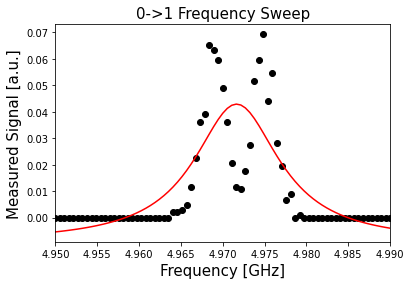

93f03e44-7379-4df8-8ee0-e7ceb17528c3
Job Status: job has successfully run


NameError: name 'rabi_y_fit' is not defined

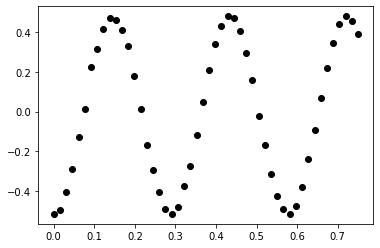

In [32]:
freq_01 = find_frequency(4.97*GHz, preprogram=[])
amp_01 = find_amplitude(freq_01, preprogram=[])


In [ ]:
pulse_01 = pulse_lib.gaussian(
    duration=drive_samples,
    amp=amp_01, 
    sigma=drive_sigma,
    name='pulse_01'
)
preprogram_12 = [
    (pulse_01, None, None)
]
freq_12 = find_frequency(4.97*GHz, preprogram=preprogram_12)
amp_12 = find_amplitude(freq_01, preprogram=preprogram_12)